# Informe - Examen Interciclo

![ups logo](http://yqsigo.com/wp-content/uploads/2018/04/LOGO-UPS.png)

**Autor:** Roberto Pacho <br>
**Materia:** Simulación <br>
**Maestro:** Ing. Diego Quisi <br>
**Fecha:** 2021-05-29

---------
## Objetivo
Consolidar los conocimientos adquiridos en clase para desarrollar simulaciones de eventos discretos.
<br>
## Introducción

El golpe económico de la crisis sanitaria del corona virus no va a ser cosa de semanas, sino de meses. Dentro de una de las etapas importantes posteriores a las elecciones presidenciales son el análisis y tendencia que tiene el actual presidente. Para ello se plantea realizar un sistema de regresión que permita identificar cual es la tendencia en base al manejo de las redes sociales (Twitter y/o Facebook) del presidente [1].

Las regresiones lineales pueden aprenden por sí mismos y en este caso obtener automáticamente esa “recta o ecuación” que buscamos con la tendencia de predicción. Para ello se puede medir el error con respecto a los puntos de entrada y el valor “Y” de salida real [3].

## Enunciado:

• Diseñe y desarrolle un modelo y/o script que permita simular el siguiente caso real:
<br>
• Obtener datos de tendencia de twitter o facebook(crawler o webscraping), para ello se puede obtener a través del 

*	**Title:** Titulo del Post/Twitter
*	**Word count:** la cantidad de palabras del artículo,
*	**of Links:** los enlaces externos que contiene,
*	**of comments:** cantidad de comentarios,
*	**Shares:** compartidos.
*	**HashTag**
*	**Etc**.

En base a ello, se pretende proponer y generar una predicción de cuántas veces será compartido un post/twitter utilizando regresión [2].


# Regresión Lineal para predicción de tendencias de post en twitter

## Importar librerias

A continuación estan todas las librerías que se utilizaran para realizar la regresión lineal, cada una de estas librerías se iran explicando a lo largo del procedimiento

In [19]:
import altair as alt #Altair en esencia lo que hace es tomar el código python y lo traduce a formato JSON que puede ser interpretado por Vega-Lite 
import matplotlib.pyplot as plt
import nest_asyncio #para permitir bucles de eventos anidados
nest_asyncio.apply()
import nltk #para el procesamiento del lenguaje natural simbólico y estadísticos
import numpy as np
import pandas as pd
import seaborn as sns #permite generar fácilmente elegantes gráficos.

import warnings #forma de advertir a los programadores sobre los cambios en el lenguaje o las características de la biblioteca en previsión de cambios incompatibles con Python
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords #Se trata de palabras muy habituales en cualquier idioma
stop_words = set(stopwords.words('spanish'))
from sklearn.metrics import mean_squared_error #Usado en el Error Cuadrático Medio para Regresión
from sklearn.model_selection import train_test_split#permite dividir un dataset en dos bloques
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import (
    cross_val_score, KFold #Se utilizará para realizar la evaluación, tomando el conjunto de datos 
)
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.linear_model import (
    RANSACRegressor,HuberRegressor
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

## Credenciales

In [4]:
import tweepy
import json

API_KEY = "iBUMsYhOnEiCheMpAcryXTVdz"
API_SECRET_KEY = "qltoXBIqtGBOQXUHuMBV6TRjZmhaY2yfjcVgvYJ9pIQ5ca18As"
ACCESS_TOKEN = "808108432486236162-sAgaq0txJyp1KNnQRdLZ75yBB88VXKC"
ACCESS_TOKEN_SECRET = "AEn3jGo8OsW2mdwqvpPLBflMPXGV02Den0NhE5sZXvIrr"

auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth,wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)


In [80]:

tweets = tweepy.Cursor(api.search, q="LassoGuillermo", tweet_mode="extended").items(3000)
    #api.search(q='LassoGuillermo', lang='es', tweet_mode='extended', max_id=id)

for tweet in tweets:
    #print(json.dumps(tweet._json, indent=4))
    tweet.id
    tweet.id_str
    #tweet.entities.screen_name
    tweet.created_at
    #tweet.listed_count
    #tweet.hashtags
    tweet.retweet_count
    texto=tweet.full_text
    palabras=texto.count(" ")
    f = open('/home/RobertoPacho/Documentos/Simulacion/examen1/LassoGuillermo1.data', 'a', encoding='utf-8')
    f.write(f"{tweet.id}"+' '+ f"{tweet.id_str}" +' '+f"{tweet.created_at}" +' '+f"{tweet.retweet_count}"+' '+f"{palabras}"+'\n')
    #f.write(json.dumps(tweet._json))
    f.close

Rate limit reached. Sleeping for: 380


## Lectura de los datos obtenidos

Una vez obtenido los datos, procedemos a leer los datos que se guardaron en el archivo json utilizando la herramienta pandas. Pandas también cuenta con la posibilidad de leer archivos json de una manera muy sencilla y a continuación lo mostramos

In [5]:
df = pd.read_csv('/home/RobertoPacho/Documentos/Simulacion/examen1/LassoGuillermo1.data',sep=" ",header=None)

df.columns = ['id','id_str','created_at','retweet_count','palabras']

df.head()

,id,id_str,created_at,retweet_count,palabras
0,1401591206438637568,1401591206438637568,2021-06-06-17:25:58,243,19.0
1,1401591480616198144,1401591480616198144,2021-06-06-17:27:03,11,22.0
2,1401591398110056450,1401591398110056450,2021-06-06-17:26:44,1,48.0
3,1401591381672538118,1401591381672538118,2021-06-06-17:26:40,495,25.0
4,1401591374391169026,1401591374391169026,2021-06-06-17:26:38,495,25.0


Estos datos son necesarios para el pre procesamiento a los datos para tenerlos preparados para entrenarlos.

## Preprocesamiento

Como habiamos comentado en el punto anterior, existe una gran cantidad de columnas ya ademas de ello, los datos estan con basura como comunmente se dice, esto afectará al modelo de regresión que realizaremos, por ello es necesario un preprocesamiento con la finalidad de enriquecer nuestro dataset y dejarlos normalizados.

### Obtenemos las columnas que necesitamos
Al tener una gran cantidad de columnas, es necesario realizar una reducción y quedarnos solamente con las columnas que realmente nos interesan, con la finalidad de centrarnos en ello y realizar el preprocesamiento solamente a dichos datos.Con esto en cuenta. obtenemos las columnas de interes, pero antes de ello hechemos un vistazo a las columnas que tenemos

In [6]:
df.columns

Index(['id', 'id_str', 'created_at', 'retweet_count', 'palabras'], dtype='object')

Con estas columnas podemos ver estas columnas que no son tan importantes para nosotros para el analisis

In [7]:
df_twitter = df[['id','id_str','created_at','retweet_count','palabras']]
df_twitter.head()

,id,id_str,created_at,retweet_count,palabras
0,1401591206438637568,1401591206438637568,2021-06-06-17:25:58,243,19.0
1,1401591480616198144,1401591480616198144,2021-06-06-17:27:03,11,22.0
2,1401591398110056450,1401591398110056450,2021-06-06-17:26:44,1,48.0
3,1401591381672538118,1401591381672538118,2021-06-06-17:26:40,495,25.0
4,1401591374391169026,1401591374391169026,2021-06-06-17:26:38,495,25.0


Con este conjunto de datos podremos trabajar

In [8]:
df_twitter['palabras'] = df_twitter.palabras.apply(lambda x: x)
df_twitter.head()

,id,id_str,created_at,retweet_count,palabras
0,1401591206438637568,1401591206438637568,2021-06-06-17:25:58,243,19.0
1,1401591480616198144,1401591480616198144,2021-06-06-17:27:03,11,22.0
2,1401591398110056450,1401591398110056450,2021-06-06-17:26:44,1,48.0
3,1401591381672538118,1401591381672538118,2021-06-06-17:26:40,495,25.0
4,1401591374391169026,1401591374391169026,2021-06-06-17:26:38,495,25.0


Con esto podemos notar como ahora la columna hashtag tiene un valor numérico. Ahora el mismo procedimiento lo realizamos con la columna mentions.

In [9]:
df_twitter['retweet_count'] = df_twitter.retweet_count.apply(lambda x: x)
df_twitter.head()

,id,id_str,created_at,retweet_count,palabras
0,1401591206438637568,1401591206438637568,2021-06-06-17:25:58,243,19.0
1,1401591480616198144,1401591480616198144,2021-06-06-17:27:03,11,22.0
2,1401591398110056450,1401591398110056450,2021-06-06-17:26:44,1,48.0
3,1401591381672538118,1401591381672538118,2021-06-06-17:26:40,495,25.0
4,1401591374391169026,1401591374391169026,2021-06-06-17:26:38,495,25.0


Con esto ya tenemos valores numéricos y podremos pasar dichos valores a nuestro modelo sin problemas, sin embargo, una cosa muy importante del tweet es la hora en la que se lo realiza, podriamos decir que un tweet es más popular si se lo realiza en horas pico a diferencia si se lo realiza a una hora de la madrugada. Con esto en cuenta procedemos a obtener la hora del time

Una vez realizado dicho proceso, podemos notar como la columna media tiene la suma de fotos y videos del tweet. Ahora procedemos a tokenizar el tweet, con la finalidad de obtener la cantidad de palabras valiosas del tweet y poder analizar si con ello también un tweet puede ser tendencia.

## Análisis Exploratorio

## El número de palabras y retweets influyen en los retweets

In [67]:
palabras = alt.Chart(df_twitter.sample(500)).mark_point(color='blue').encode(
    x='retweet_count',
    y='palabras'
).properties(title='retweets por palabras').interactive()

retweet = alt.Chart(df_twitter.sample(500)).mark_point(color='green').encode(
    x='retweet_count',
    y='palabras'
).properties(title='retweets por palabras').interactive()

In [68]:
chart = (palabras&retweet)
chart

alt.VConcatChart(...)

Podemos notar que nuestra hipótesis es cierta, notamos como a medida que aumentan los likes y replies el número de retweets aumentan, obviamente esto dependera de otros factores, sin embargo podemos ver una tendencia creciente, ademas vemos como la relación de los likes en los retweets es muy grande debido a su manera de crecer de manera un poco más suavizada a diferencia de los replies.

## El mapa de calor nos ayudar a obtener mejores conclusiones

Text(0.5, 1.0, 'Mapa de correlación de df_twitter')

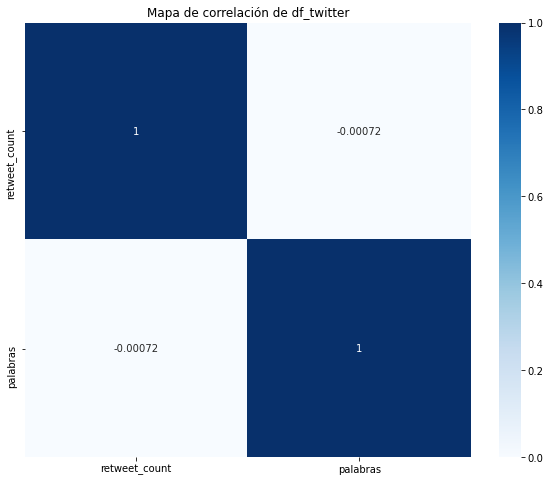

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_twitter.corr(),annot=True,ax=ax,cmap="Blues")
ax.set_title('Mapa de correlación de df_twitter')

## Modelo de regresión

Ahora procedemos a realizar los modelos de regresión para predecir la popularidad de un tweet dado ciertas entreadas, en este caso escogímos como entrada los likes y replies, mientras que para la salida serán los retweets. Para realizar este modelo tomaremos muy en cuenta el problema de overfitting, para ello realizaremos una división de train y test diferente utilizando cross validation.

### División train test con cross validation

Para estom utilizamos el cross_val_score que nos permite obtener un score de la validación cruzada tomando en cuenta el modelo y los valores de entrada y salida. Hemos probado con distintos regresores, entre los cuales estan lineales,regularizadores y robustos. Se obtuvo los siguientes resultados

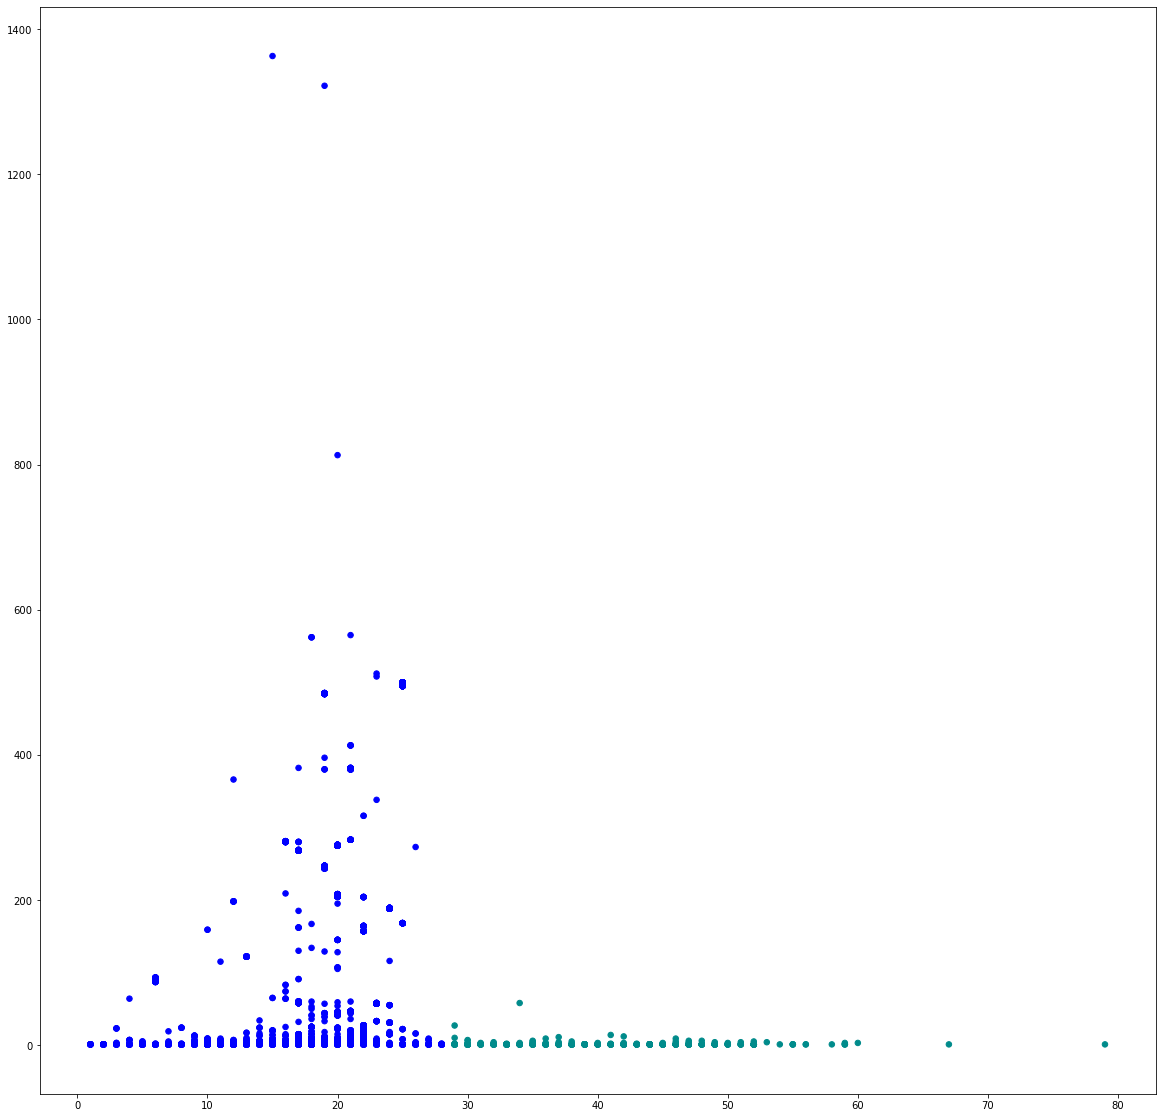

In [13]:
#vamos a Visualizar los datos de entrada
colores=['darkcyan','blue']
tamanios=[30,60]

# Vamos a RECORTAR los datos en la zona donde se concentran más los puntos
# esto es en el eje X: entre 0 y 3.500
# y en el eje Y: entre 0 y 80.000
filtered_data = df[(df['palabras'] <= 3500) & (df['retweet_count'] <= 80000)]

f1 = filtered_data['palabras'].values
f2 = filtered_data['retweet_count'].values

# Vamos a pintar en colores los puntos por debajo y por encima de la media de Cantidad de Palabras
asignar=[]
for index, row in filtered_data.iterrows():
    if(row['palabras']>28):
        asignar.append(colores[0])
    else:
        asignar.append(colores[1])
    
plt.scatter(f1, f2, c=asignar, s=tamanios[0])
plt.gcf().set_size_inches(20, 20)
plt.show()

In [15]:
# Asignamos nuestra variable de entrada X para entrenamiento y las etiquetas Y.
dataX =filtered_data[["palabras"]]
X_train = np.array(dataX)
y_train = filtered_data['retweet_count'].values

In [39]:
# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()

# Entrenamiento del modelo
regr.fit(X_train, y_train)

# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
y_pred = regr.predict(X_train)

print('coeficienetes: \n', regr.coef_)
# Interseccion el eje Y (en X=0)
print('Terminos independientes: \n', regr.intercept_)
print("Error cuadratico medio: %.2f" % mean_squared_error(y_train, y_pred))
# El mejor puntaje es un 1.0
print('puntos de varianza: %.4f' % r2_score(y_train, y_pred))

coeficienetes: 
 [-0.01062594]
Terminos independientes: 
 89.83849637490603
Error cuadratico medio: 21230.44
puntos de varianza: 0.0000


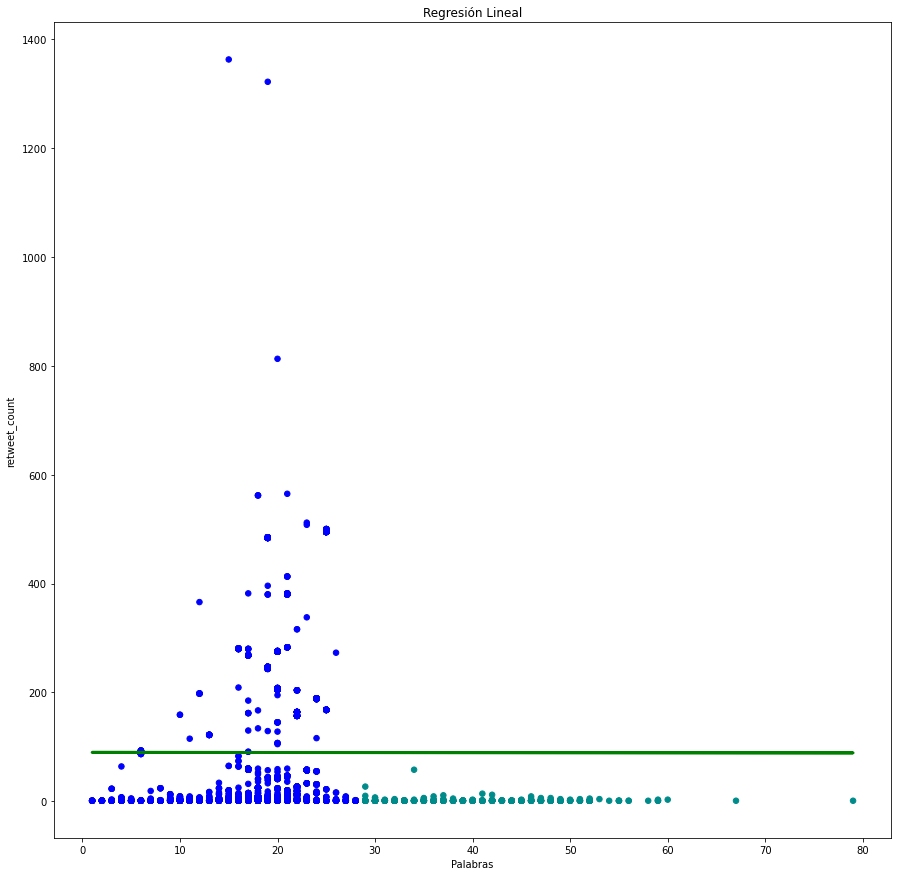

In [34]:
plt.scatter(X_train[:,0], y_train,  c=asignar, s=tamanios[0])
plt.plot(X_train[:,0], y_pred, color='green', linewidth=3)

plt.xlabel('Palabras')
plt.ylabel('retweet_count')
plt.title('Regresión Lineal')
plt.gcf().set_size_inches(15, 15)
plt.show()

In [80]:
#Para realizar una prediccion vamos a definir el numero de palabras y nos mostrara las veces que va a ser retw
predic = regr.predict([[50]])
print(int(predic))

89


## Proceso de vacunación

• Posteriormente se debe seguir un procesos de vacunación en los recintos electorales que se describe a continuación:

#### Solo se va a tener en cuanta uno de los recintos electorales (investigar datos de cuantas personas asisten a votar).
#### Tomar los resultados de la regresión para la vacuna según la llegada.
#### Se tiene una promedio que el 80% de personas realizaran el proceso de vacunación dentro del Ecuador.
#### Dentro del procesos se tiene que alrededor del 5% - 10% no podrán vacunarse.
#### Las personas solo tiene un recinto electoral para realizar el proceso.
#### Las personas realizan la primera vacuna y 30 días después la segunda vacuna.
#### La persona se acerca a la mesa y hacen fila en caso de ser necesario para recibir la vacuna.
#### Realiza la vacunación en un tiempo aleatorio entre 5 a 10 minutos.
#### Debe esperar 20 minutos dentro del establecimiento para verificar que no tenga problemas de salud.
#### La persona recibe su certificado de vacunación y la fecha de la próxima vacuna entre 2 – 3 minutos.
#### La persona sale del recinto electoral.
#### Regresan para la próxima fecha y se repite el ciclo.



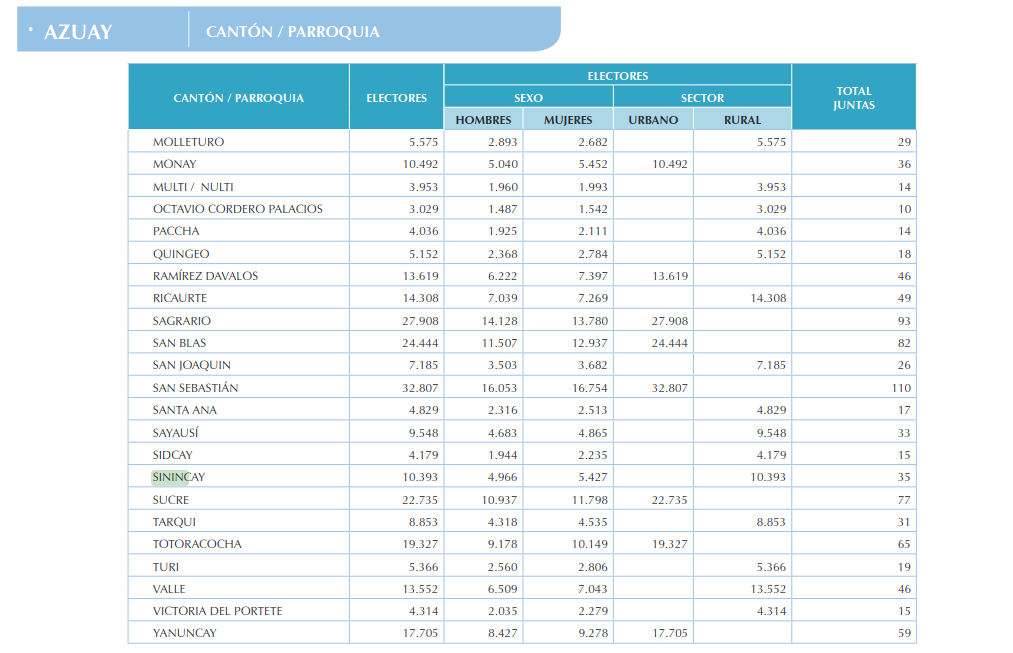

In [70]:
import datetime as dt
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)
import random
import simpy

from datetime import datetime

In [78]:
NUM_VACUNAS                 = 10395
NUM_PERSONAS_VACUNAR        = 10393
NUM_PERSONAS_EXAM           = 15
NUM_PERSONAS_CERTIFICADOS   = 15
TIME_SIMULATION             = 540
INTERVAL                    = 5
SIGUIENTE_VACUNA            = datetime.now().strftime('%Y/%m/%d')
LIST_DATA                   = []


class Person():
    def __init__(self, name='', problem=0):
        self.name = name
        self.problem = problem
        self.cite = ''


class Vacunation():
    def __init__(self, env):
        global NUM_PERSONAS_VACUNAR, NUM_PERSONAS_EXAM, NUM_PERSONAS_CERTIFICADOS, NUM_VACUNAS
        self.env = env
        self.person_v = simpy.Resource(env, NUM_PERSONAS_VACUNAR)
        self.person_e = simpy.Resource(env, NUM_PERSONAS_EXAM)
        self.person_c = simpy.Resource(env, NUM_PERSONAS_CERTIFICADOS)
        self.vaccines = NUM_VACUNAS
        self.exam = None
        self.probability = [0.8, 0.2]
        self.exam_result = [0, 1]

    def _exam_process(self, time):
        self.exam = random.choices(self.exam_result, self.probability, k=1)
        yield self.env.timeout(time)

    def _data_process(self, time):
        yield self.env.timeout(time)

    def _vaccine_process(self, time):
        self.vaccines = self.vaccines-1
        yield self.env.timeout(time)

    def _certificate_process(self, time):
        yield self.env.timeout(time)

    def _exit_process(self, time):
        yield self.env.timeout(time)

    def _print_process(self, person, hour, action):
        print(
            'persona:[{}] - hora:[{:,.2f}] - acción: [{}]'.format(person, hour, action))

    def _vacunation_process(self, person):
        global LIST_DATA

        time_exam        = 0
        time_data        = 0
        time_vaccine     = 0
        time_certificate = 0
        time_wait        = 0
        time_wait_mean   = 0
        time_exit        = 0
        indicate_vaccine = 0

        self._print_process(person.name, self.env.now, 'llega al recinto')
        wait=self.env.now
        with self.person_e.request() as mesa:
            yield mesa
            self._print_process(person.name, self.env.now, 'llega a la mesa despues de esperar {}'.format(self.env.now-wait))
            time_wait = self.env.now -wait
            time_wait_mean+=time_wait
            time_exam = 20 #Debe esperar 20 minutos dentro del establecimiento para verificar que no tenga problemas de salud.
            yield self.env.process(self._exam_process(time_exam))
            
        try:
            if(self.vaccines>0):
                try:
                    if(self.exam[0] == 0):
                            indicate_vaccine = 1
                            self._print_process(person.name, self.env.now, 'pasa el proceso de revisión')
                            wait=self.env.now
                            with self.person_c.request() as certificate:
                                yield certificate
                                
                                time_data = random.randint(2, 4)
                                time_wait = self.env.now -wait
                                time_wait_mean+=time_wait
                                yield self.env.process(self._data_process(time_data))
                                self._print_process(person.name, self.env.now, 'se tomaron los datos correctamente')
                            wait=self.env.now
                            with self.person_v.request() as vaccine:
                                yield vaccine
                                try:
                                    if(self.vaccines > 0):
                                        time_wait = self.env.now - wait
                                        time_wait_mean+=time_wait
                                        
                                        time_vaccine = random.randint(5, 10)
                                        yield env.process(self._vaccine_process(time_vaccine))
                                        self._print_process(person.name, self.env.now, 'vacuna puesta')

                                        time_certificate = random.randint(1, 3)
                                        yield env.process(self._certificate_process(time_certificate))
                                        person.cite = datetime.strftime(datetime.strptime(SIGUIENTE_VACUNA, '%Y/%m/%d')+dt.timedelta(days=21), '%Y/%m/%d')
                                        self._print_process(person.name, self.env.now, 'se le entrega el certificado con fecha a la segunda dosis {}'.format(person.cite))
                                    else:
                                        raise VaccineException
                                except VaccineException:
                                    person.cite = datetime.strftime(datetime.strptime(SIGUIENTE_VACUNA, '%Y/%m/%d')+dt.timedelta(days=1), '%Y/%m/%d')
                                    indicate_vaccine = 0
                                    self._print_process(person.name, self.env.now, 'no se realizo la vacuna. Proxima fecha {}'.format(person.cite))
                    else:
                        raise ProblemExamException
                        except ProblemExamException:
                        person.cite = datetime.strftime(datetime.strptime(SIGUIENTE_VACUNA,'%Y/%m/%d')+dt.timedelta(days=random.randint(2,5)),'%Y/%m/%d')
                        indicate_vaccine=0
                        self._print_process(person.name,self.env.now,'no paso el proceso de revisión. Proxima fecha {}'.format(person.cite))

                time_exit = random.randint(1,5)
                yield env.process(self._exit_process(time_exit))
                self._print_process(person.name,self.env.now,'sale del recinto')
                LIST_DATA.append((person.name,time_exam,time_data,time_vaccine,time_certificate,time_exit,time_wait_mean,indicate_vaccine))
            else:
                raise VaccineException
        except VaccineException:
            print('No hay vacunas')

class Simulation():
    def __init__(self,init):
        self.init = init
        self.name = 'persona_{}'
    
    
    def _execute_simulation(self,env):
        global INTERVAL
        vacunation = Vacunation(env)
        
        self._init_persons(env,vacunation)
        
        while True:
            yield env.timeout(random.randint(INTERVAL-2,INTERVAL))
            name = self.name.format(self.init)
            person = Person(name)
            env.process(vacunation._vacunation_process(person))
            self.init+=1
        
    def _init_persons(self,env,vacunation):
        for i in range(self.init):
            name = self.name.format(i)
            person = Person(name)
            env.process(vacunation._vacunation_process(person))
            
env = simpy.Environment()
simulation = Simulation(7)
env.process(simulation._execute_simulation(env))
env.run(until=TIME_SIMULATION)

persona:[persona_0] - hora:[0.00] - acción: [llega al recinto]
persona:[persona_1] - hora:[0.00] - acción: [llega al recinto]
persona:[persona_2] - hora:[0.00] - acción: [llega al recinto]
persona:[persona_3] - hora:[0.00] - acción: [llega al recinto]
persona:[persona_4] - hora:[0.00] - acción: [llega al recinto]
persona:[persona_5] - hora:[0.00] - acción: [llega al recinto]
persona:[persona_6] - hora:[0.00] - acción: [llega al recinto]
persona:[persona_0] - hora:[0.00] - acción: [llega a la mesa despues de esperar 0]
persona:[persona_1] - hora:[0.00] - acción: [llega a la mesa despues de esperar 0]
persona:[persona_2] - hora:[0.00] - acción: [llega a la mesa despues de esperar 0]
persona:[persona_3] - hora:[0.00] - acción: [llega a la mesa despues de esperar 0]
persona:[persona_4] - hora:[0.00] - acción: [llega a la mesa despues de esperar 0]
persona:[persona_5] - hora:[0.00] - acción: [llega a la mesa despues de esperar 0]
persona:[persona_6] - hora:[0.00] - acción: [llega a la mesa 

## Referencias
### https://cne.gob.ec/documents/publicaciones/2014/libro_estadistica_del_registro_electoral-r.pdf